# Workflow steps:
1. Prepare and load Data
2. Build Model
3. Fit
4. Predict and model Evaluation
5. Save and Load Models

In [195]:
# Imports
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from pathlib import Path

In [196]:
torch.__version__

'2.0.1+cu118'

#Prepare and load Data

In [197]:
# Define base parameters fro data generation
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

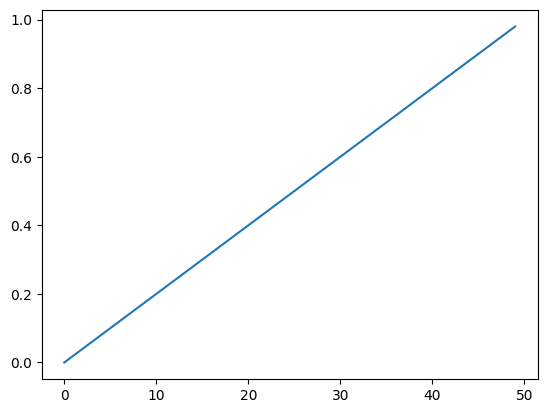

In [198]:
plt.plot(X)

### Data split


In [199]:
split_count = int(0.8 * len(X))
X_train, y_train = X[:split_count], y[:split_count]
X_test, y_test = X[split_count:], y[split_count:]

get_length = lambda x: print(len(x))
get_length(X_train), get_length(y_train), get_length(X_test), get_length(y_test)

40
40
10
10


(None, None, None, None)

In [200]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

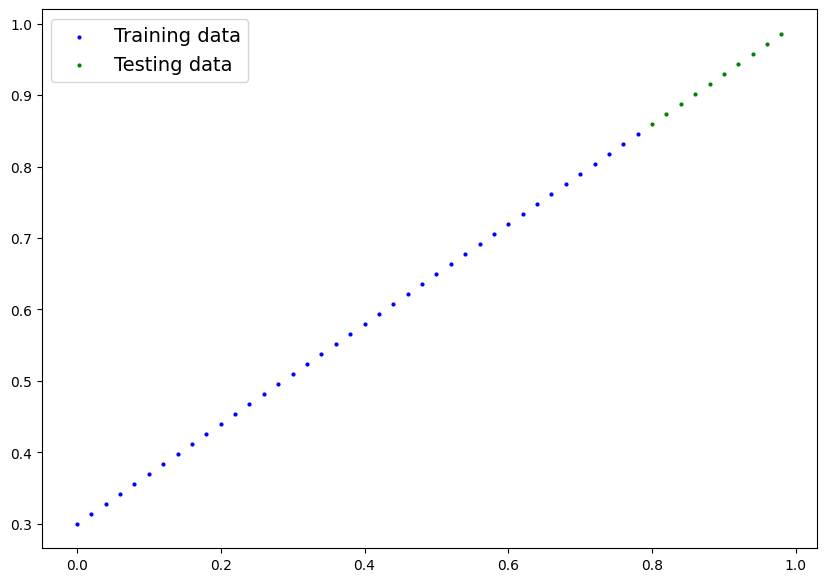

In [201]:
# show data split representation
plot_predictions()

# Train a model

In [202]:
# class for linear regression
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True)) # start with random values
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

### Look into both Gradient descent and Backpropagation
This is done by Pytorch by default
* https://www.youtube.com/watch?v=IHZwWFHWa-w
* https://www.youtube.com/watch?v=Ilg3gGewQ5U

In [203]:
# Check the model details
linear_model = LinearRegression()

list(linear_model.parameters())

[Parameter containing:
 tensor([0.1081], requires_grad=True),
 Parameter containing:
 tensor([-0.4376], requires_grad=True)]

In [204]:
# List named parameters
linear_model.state_dict()

OrderedDict([('weights', tensor([0.1081])), ('bias', tensor([-0.4376]))])

# Model Predictions
`torch.inference_mode()` - for Torch predictions based on selected model

In [205]:
# Make model predictions
with torch.inference_mode(): # this way of inferencing is faster, because it does not keep track of Gradient
    y_preds = linear_model(X_test)

y_preds

tensor([[-0.3511],
        [-0.3489],
        [-0.3468],
        [-0.3446],
        [-0.3424],
        [-0.3403],
        [-0.3381],
        [-0.3359],
        [-0.3338],
        [-0.3316]])

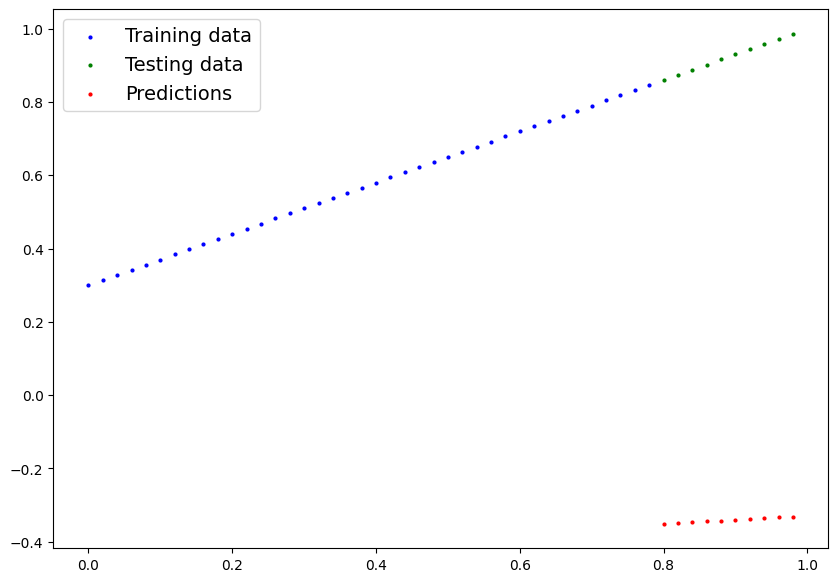

In [206]:
plot_predictions(predictions=y_preds)

## Model training parameter setup

In [207]:
# Setup the loss function
loss_fct = nn.L1Loss()

In [208]:
# Setup the optimizer
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.01)

# Build the training loop
*Basic steps:*
* Loop through the data
* Forward prop
* Compute the loss
* Optimize the zero grad
* Back prop
* Optimizer step

In [209]:
torch.manual_seed(21)
epochs = 250

# Track experiments
epoch_history = []
loss_history = []
test_loss_history = []

for epoch in tqdm(range(epochs)):

    linear_model.train() # sets all params that req gradients to req gradients

    y_pred = linear_model(X_train) #   -> Forward pass
    loss = loss_fct(y_pred, y_train) # -> Compute loss
    optimizer.zero_grad() #            -> Optimize zero grad (reset the values so it does NOT accumulate in the loop)
    loss.backward() #                  -> Back prop with respect to model params
    optimizer.step() #                 -> Gradient descent

    linear_model.eval() # turn off gradient track

    with torch.inference_mode():
        test_pred = linear_model(X_test) # Forward pass for testing data
        test_loss = loss_fct(test_pred, y_test) # Get the loss value for prediction

    if epoch % 10 == 0:
        epoch_history.append(epoch)
        loss_history.append(loss)
        test_loss_history.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")



100%|██████████| 250/250 [00:00<00:00, 1985.30it/s]

Epoch: 0 | Loss: 0.9684009552001953 | Test loss: 1.250878930091858
Epoch: 10 | Loss: 0.8531911969184875 | Test loss: 1.1161689758300781
Epoch: 20 | Loss: 0.7379812002182007 | Test loss: 0.9814589619636536
Epoch: 30 | Loss: 0.6227710843086243 | Test loss: 0.8467487096786499
Epoch: 40 | Loss: 0.5075610876083374 | Test loss: 0.7120388746261597
Epoch: 50 | Loss: 0.3923511505126953 | Test loss: 0.5773289203643799
Epoch: 60 | Loss: 0.27714118361473083 | Test loss: 0.4426189959049225
Epoch: 70 | Loss: 0.16193118691444397 | Test loss: 0.3079090714454651
Epoch: 80 | Loss: 0.07240105420351028 | Test loss: 0.1921069175004959
Epoch: 90 | Loss: 0.051040809601545334 | Test loss: 0.13573619723320007
Epoch: 100 | Loss: 0.04554155841469765 | Test loss: 0.11194107681512833
Epoch: 110 | Loss: 0.04191133752465248 | Test loss: 0.09956499189138412
Epoch: 120 | Loss: 0.03843002766370773 | Test loss: 0.08923182636499405
Epoch: 130 | Loss: 0.034995339810848236 | Test loss: 0.08095929026603699
Epoch: 140 | Loss

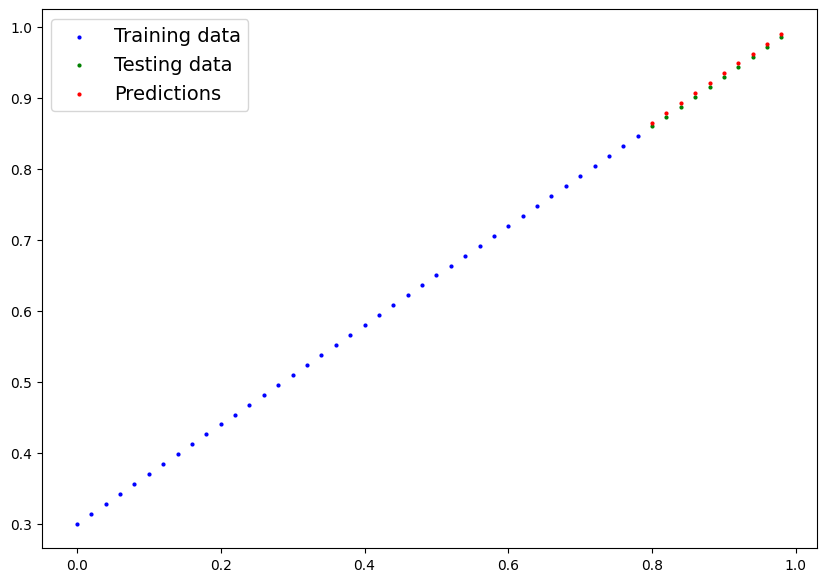

In [210]:
plot_predictions(predictions=test_pred)

### Visualize training history

In [211]:
np_value_conversion = lambda values: np.array(torch.tensor(values).numpy())

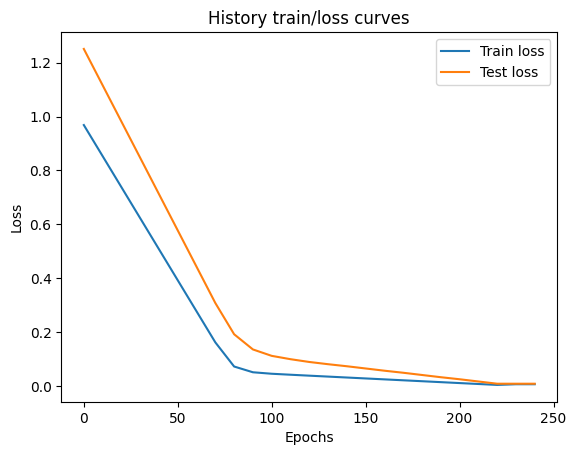

In [212]:
plt.plot(np_value_conversion(epoch_history), np_value_conversion(loss_history), label="Train loss")
plt.plot(np_value_conversion(epoch_history), np_value_conversion(test_loss_history), label="Test loss")
plt.title("History train/loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Saving a Pytorch model
There are multiple ways of doing this:
* `torch.save()` - save a Pytorch obj in `pickle` format
* `torch.load()` - load the model
* `torch.nn.Module.load_state_dict()` - load a model's saved state dictionary

In [213]:
# Create root dir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")

torch.save(obj=linear_model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/pytorch_workflow_model_0.pth


In [214]:
! ls models/

pytorch_workflow_model_0.pth


## Load the saved model
Done by loading the state dict of the model

In [215]:
# To load a state dict, NEED to instantiate a new instance of the model class
loaded_model = LinearRegression()

# Update the instance with the saved state dict
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

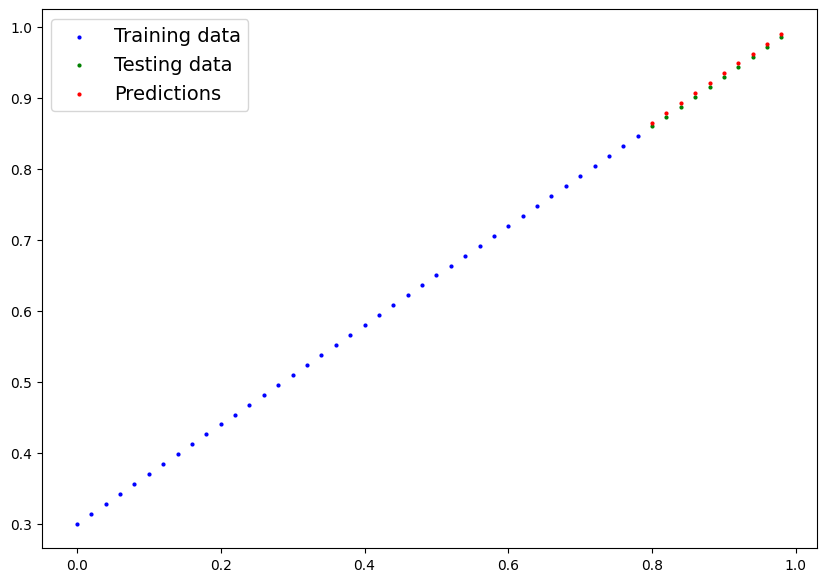

In [216]:
# Test the saved model
loaded_model.eval()
with torch.inference_mode():
    loaded_model_prediction = loaded_model(X_test)

plot_predictions(predictions=loaded_model_prediction)

In [217]:
test_pred == loaded_model_prediction

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Build a Pytorch Linear model using `torch.nn`
Build the same model as before, but leveraging the neural network capabilities from Pytorch this time

In [218]:
X_train.shape, y_train.shape

(torch.Size([40, 1]), torch.Size([40, 1]))

In [219]:
# The Linear layer already implements our regression formula from before
# And it also creates the parameters that we need behind the scenes

class LinearRegressionV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for model params
        self.linear_layer = nn.Linear(in_features=1, out_features=1) # implements linear transform

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [220]:
regression_model = LinearRegressionV2()
regression_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.1348]])),
             ('linear_layer.bias', tensor([-0.4924]))])

## Training the new model

In [221]:
# Set training parameters
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(params=regression_model.parameters(), lr=0.01)

In [222]:
torch.manual_seed(21)
epochs = 250

# Track experiments
epoch_history = []
loss_history = []
test_loss_history = []

for epoch in tqdm(range(epochs)):

    regression_model.train()

    y_pred = regression_model(X_train)
    loss = loss_fct(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    regression_model.eval() # turn off gradient track

    with torch.inference_mode():
        test_pred = regression_model(X_test) # Forward pass for testing data
        test_loss = loss_fct(test_pred, y_test) # Get the loss value for prediction

    if epoch % 10 == 0:
        epoch_history.append(epoch)
        loss_history.append(loss)
        test_loss_history.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

100%|██████████| 250/250 [00:00<00:00, 1244.88it/s]

Epoch: 0 | Loss: 1.012826919555664 | Test loss: 1.2765411138534546
Epoch: 10 | Loss: 0.8738270998001099 | Test loss: 1.0875413417816162
Epoch: 20 | Loss: 0.7348271012306213 | Test loss: 0.8985415697097778
Epoch: 30 | Loss: 0.5958272218704224 | Test loss: 0.7095416188240051
Epoch: 40 | Loss: 0.45682716369628906 | Test loss: 0.5205416679382324
Epoch: 50 | Loss: 0.3178272247314453 | Test loss: 0.33154165744781494
Epoch: 60 | Loss: 0.1788271963596344 | Test loss: 0.14254172146320343
Epoch: 70 | Loss: 0.04166286438703537 | Test loss: 0.045862000435590744
Epoch: 80 | Loss: 0.04789700359106064 | Test loss: 0.1317216455936432
Epoch: 90 | Loss: 0.029338669031858444 | Test loss: 0.07453663647174835
Epoch: 100 | Loss: 0.02264927327632904 | Test loss: 0.020449835807085037
Epoch: 110 | Loss: 0.013168344274163246 | Test loss: 0.034867435693740845
Epoch: 120 | Loss: 0.0054022083058953285 | Test loss: 0.004688626620918512
Epoch: 130 | Loss: 0.0025738112162798643 | Test loss: 0.005823677871376276
Epoch

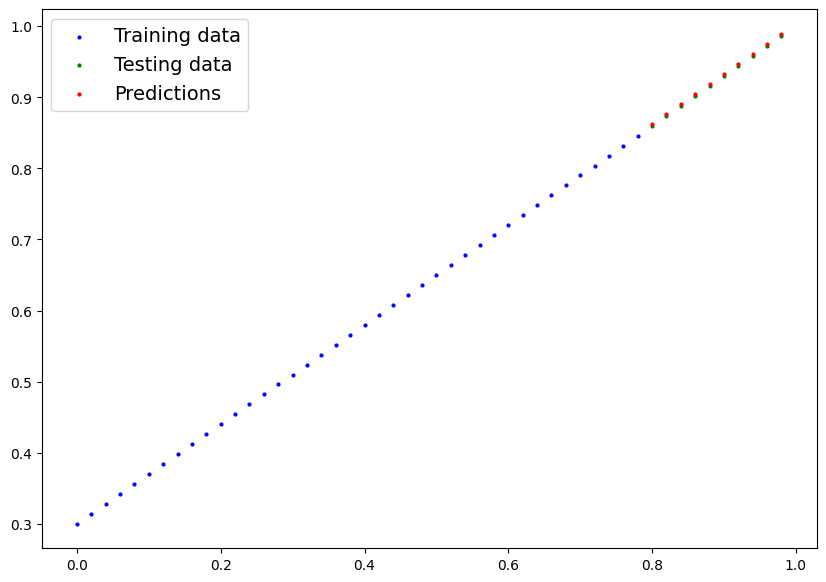

In [224]:
plot_predictions(predictions=test_pred)

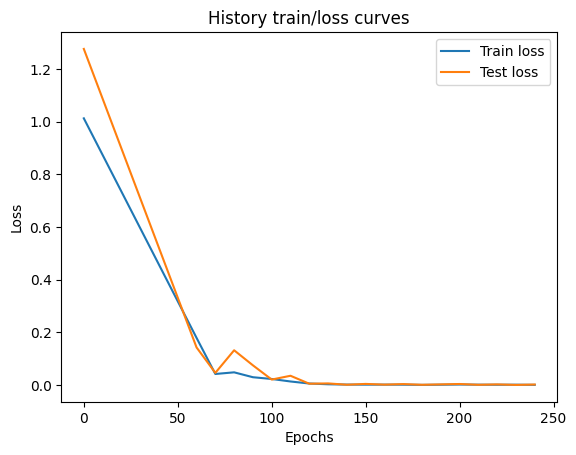

In [223]:
plt.plot(np_value_conversion(epoch_history), np_value_conversion(loss_history), label="Train loss")
plt.plot(np_value_conversion(epoch_history), np_value_conversion(test_loss_history), label="Test loss")
plt.title("History train/loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [225]:
# Save the model
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

SECOND_MODEL_NAME = "pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / SECOND_MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")

torch.save(obj=regression_model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/pytorch_workflow_model_1.pth
